In [5]:
import pandas as pd
from functools import reduce

# Load fish data
fish_abundance_df = pd.read_csv('./fish_species_abundance.csv')
fish_yearly_df = pd.read_csv('./raw/yearly_fish_counts.csv')

fish_abundance_clean = fish_abundance_df[['Common Name', 'Station Number', 'Station Description', 'Sample Years', 'Total Fish Count', 'Yearly Average', 'Waterway', 'x', 'y']]
fish_yearly_clean = fish_yearly_df[['Fish Count', 'Species List', 'Species Count', 'Station Number', 'Station Name', 'Waterway', 'Year', 'x', 'y']]

# Output preview
print(fish_abundance_clean.head())
print(fish_yearly_clean.head())

             Common Name  Station Number  \
0          golden shiner              78   
1               bluegill             106   
2           gizzard shad             106   
3  blackstripe topminnow              31   
4           gizzard shad              31   

                                 Station Description Sample Years  \
0                        Higgins Creek at Wille Road         2001   
1  West Fork North Branch Chicago River at Dundee...         2001   
2  West Fork North Branch Chicago River at Dundee...         2001   
3  Middle Fork North Branch Chicago River at Lake...         2001   
4  Middle Fork North Branch Chicago River at Lake...         2001   

   Total Fish Count  Yearly Average                                Waterway  \
0                 1               1                           Higgins Creek   
1                 1               1    West Fork North Branch Chicago River   
2                 3               3    West Fork North Branch Chicago River   
3   

In [19]:
import pandas as pd
from functools import reduce

# 只保留字段标准名称以免 KeyError
chemical_files = [
    'Phosphorous.csv', 'NO2_NO3.csv', 'Fecal_Coliform.csv', 'Chlorophyll-A.csv', 'NH3.csv',
    'Chloride.csv', 'TKN.csv', 'Total_Dissolved_Solids.csv', 'SO4.csv', 'Suspended_Solids.csv', 'TOC.csv'
]

chemical_dfs = []

for file in chemical_files:
    df = pd.read_csv(f'./{file}')
    param = file.replace('.csv', '')

    # 统一字段名
    if 'Result Average' in df.columns:
        avg_col = 'Result Average'
    elif 'Result Median' in df.columns:
        avg_col = 'Result Median'
    else:
        print(f'⚠️ 无法识别平均值字段: {file}')
        continue

    # 统一字段选择和重命名
    df_clean = df.rename(columns={
        avg_col: f'{param}_Average',
        'Result Min': f'{param}_Min',
        'Result Max': f'{param}_Max'
    })

    # 选择通用字段，考虑文件可能字段不同
    keep_cols = ['Station Name', 'Waterway', 'Year', f'{param}_Average', f'{param}_Min', f'{param}_Max', 'x', 'y']
    df_clean = df_clean[[col for col in keep_cols if col in df_clean.columns]]

    chemical_dfs.append(df_clean)

# 合并所有 chemical 数据
chemical_merged_df = reduce(lambda left, right: pd.merge(
    left, right, on=['Station Name', 'Waterway', 'Year', 'x', 'y'], how='outer'
), chemical_dfs)

# 保存为CSV
chemical_merged_df.to_csv('chemical_water_quality_cleaned.csv', index=False)

✅ 已成功导出 chemical 数据为 chemical_water_quality_cleaned.csv


In [24]:
combined_df = pd.merge(fish_yearly_clean, chemical_merged_df, on=['Station Name', 'Waterway', 'Year', 'x', 'y'], how='left')


In [6]:
combined_df = pd.read_csv('./combined_df.csv')


In [13]:
import pandas as pd

# 如果你还没导入文件：
# combined_df = pd.read_csv('combined_df.csv')

def extract_species_counts(species_string):
    species_dict = {}
    if pd.isna(species_string):
        return species_dict
    
    parts = species_string.split(',')
    for part in parts:
        part = part.strip()
        if part:
            tokens = part.split()
            try:
                count = int(tokens[0])
                species = ' '.join(tokens[1:]).lower()
                species_dict[species] = species_dict.get(species, 0) + count
            except (ValueError, IndexError):
                continue
    return species_dict

# 应用函数并展开为 DataFrame
species_dicts = combined_df['Species List'].apply(extract_species_counts)
species_df = pd.DataFrame(species_dicts.tolist()).fillna(0).astype(int)

# 合并新的鱼类列
combined_expanded = pd.concat([combined_df.drop(columns=['Species List']), species_df], axis=1)

# 保存结果
combined_expanded.to_csv('combined_df_expanded_species.csv', index=False)
print("✅ 成功生成每个鱼种作为独立列的文件：combined_df_expanded_species.csv")


✅ 成功生成每个鱼种作为独立列的文件：combined_df_expanded_species.csv


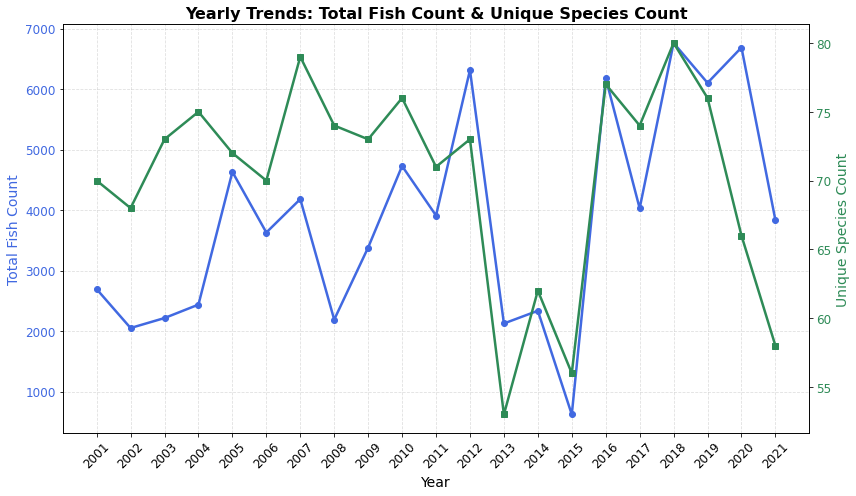

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')

# 鱼类列识别
non_species_cols = ['Fish Count', 'Species Count', 'Station Number', 'Station Name', 'Waterway', 'Year', 'x', 'y']
fish_columns = [col for col in df.columns if col not in non_species_cols and not col.startswith('Unnamed')]

# 鱼类列转整数
df[fish_columns] = df[fish_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df['Year'] = df['Year'].astype(int)

# 计算统计
total_fish_by_year = df.groupby('Year')['Fish Count'].sum()
species_presence = df.groupby('Year')[fish_columns].apply(
    lambda x: ((x > 0).any(axis=0)).sum()
)

# 🔧 转换为一维 numpy 数组
x_years = total_fish_by_year.index.to_numpy()
fish_counts = total_fish_by_year.to_numpy().reshape(-1)  # 保证是一维
species_counts = species_presence.to_numpy().reshape(-1)

# 🎨 绘图
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(x_years, fish_counts, color='royalblue', linewidth=2.5, marker='o', label='Total Fish Count')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Fish Count', color='royalblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(which='major', linestyle='--', alpha=0.4)

# 第二个 y 轴
ax2 = ax1.twinx()
ax2.plot(x_years, species_counts, color='seagreen', linewidth=2.5, marker='s', label='Unique Species Count')
ax2.set_ylabel('Unique Species Count', color='seagreen', fontsize=14)
ax2.tick_params(axis='y', labelcolor='seagreen')
ax2.tick_params(axis='both', labelsize=12)

# 设置年份为整数刻度
ax1.set_xticks(sorted(x_years))
ax1.set_xticklabels(sorted(x_years), rotation=45)

plt.title('Yearly Trends: Total Fish Count & Unique Species Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# 读取原始数据
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)

# 所有年份总数
all_years = sorted(df['Year'].unique())
num_years = len(all_years)

# 设定阈值（比如 90% 年份）
threshold = int(0.9 * num_years)

# 统计每个站点的覆盖年份数
station_year_counts = df.groupby('Station Name')['Year'].nunique()

# 保留那些年份覆盖数 ≥ 阈值 的站点
almost_always_stations = station_year_counts[station_year_counts >= threshold].index

# 过滤数据
df_cleaned = df[df['Station Name'].isin(almost_always_stations)].copy()

# 输出结果
df_cleaned.to_csv('combined_df_90percent_stations.csv', index=False)
print(f"✅ 清洗完成：保留了 {len(almost_always_stations)} 个站点，至少出现在 {threshold} 年份（共 {num_years} 年）。")


✅ 清洗完成：保留了 10 个站点，至少出现在 18 年份（共 21 年）。


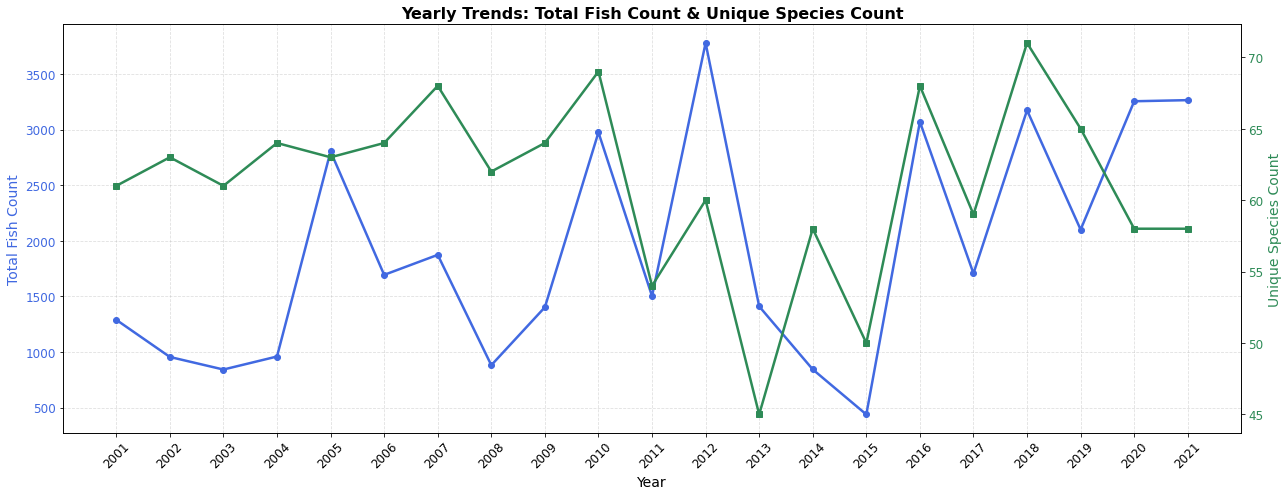

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = df_cleaned

# 鱼类列识别
non_species_cols = ['Fish Count', 'Species Count', 'Station Number', 'Station Name', 'Waterway', 'Year', 'x', 'y']
fish_columns = [col for col in df.columns if col not in non_species_cols and not col.startswith('Unnamed')]

# 鱼类列转整数
df[fish_columns] = df[fish_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
df['Year'] = df['Year'].astype(int)

# 计算统计
total_fish_by_year = df.groupby('Year')['Fish Count'].sum()
species_presence = df.groupby('Year')[fish_columns].apply(
    lambda x: ((x > 0).any(axis=0)).sum()
)

# 🔧 转换为一维 numpy 数组
x_years = total_fish_by_year.index.to_numpy()
fish_counts = total_fish_by_year.to_numpy().reshape(-1)  # 保证是一维
species_counts = species_presence.to_numpy().reshape(-1)

# 🎨 绘图
fig, ax1 = plt.subplots(figsize=(18, 7))

ax1.plot(x_years, fish_counts, color='royalblue', linewidth=2.5, marker='o', label='Total Fish Count')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Total Fish Count', color='royalblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(which='major', linestyle='--', alpha=0.4)

# 第二个 y 轴
ax2 = ax1.twinx()
ax2.plot(x_years, species_counts, color='seagreen', linewidth=2.5, marker='s', label='Unique Species Count')
ax2.set_ylabel('Unique Species Count', color='seagreen', fontsize=14)
ax2.tick_params(axis='y', labelcolor='seagreen')
ax2.tick_params(axis='both', labelsize=12)

# 设置年份为整数刻度
ax1.set_xticks(sorted(x_years))
ax1.set_xticklabels(sorted(x_years), rotation=45)

plt.title('Yearly Trends: Total Fish Count & Unique Species Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



In [30]:
import pandas as pd

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)

# 去掉 2013 和 2014 年
df_filtered = df[~df['Year'].isin([2013, 2014,2015])].copy()

# 获取剩下的年份集合
remaining_years = sorted(df_filtered['Year'].unique())
num_years = len(remaining_years)

# 统计每个站点在这些年份中出现的次数
station_year_counts = df_filtered.groupby('Station Name')['Year'].nunique()

# 筛选出在所有剩余年份都出现的站点
consistent_stations = station_year_counts[station_year_counts == num_years].index

# 过滤原始数据
df_cleaned = df_filtered[df_filtered['Station Name'].isin(consistent_stations)].copy()

# 保存清洗后的数据
df_cleaned.to_csv('combined_df_exclude2013_2014_2015_consistent.csv', index=False)

print(f"✅ 清洗完成：已排除 2013 和 2014 和 2015年，共保留 {len(consistent_stations)} 个在剩余年份中全部出现的站点。")


✅ 清洗完成：已排除 2013 和 2014 年，共保留 3 个在剩余年份中全部出现的站点。


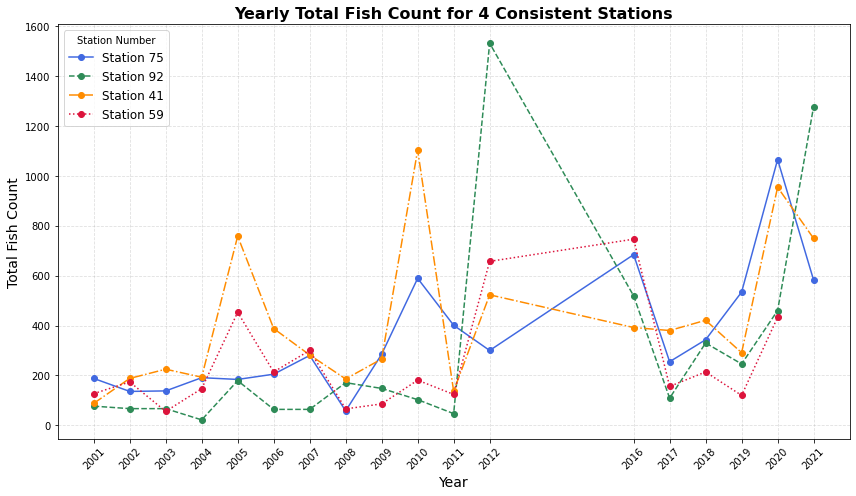

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)

# 排除数据稀少的年份
df = df[~df['Year'].isin([2013, 2014, 2015])]

# 你提供的 4 个 consistent station number
consistent_station_numbers = [75, 92, 41, 59]

# 筛选数据
df = df[df['Station Number'].isin(consistent_station_numbers)]

# 可选的颜色和线型风格
colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']
linestyles = ['-', '--', '-.', ':']

# 画图
plt.figure(figsize=(12, 7))

for i, station in enumerate(consistent_station_numbers):
    df_station = df[df['Station Number'] == station]
    yearly_fish = df_station.groupby('Year')['Fish Count'].sum()
    
    # 🔧 保证是1D numpy array
    x = yearly_fish.index.to_numpy()
    y = yearly_fish.to_numpy().flatten()

    plt.plot(
        x,
        y,
        marker='o',
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        label=f'Station {station}'
    )

# 图表样式美化
plt.title('Yearly Total Fish Count for 4 Consistent Stations', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Fish Count', fontsize=14)
plt.xticks(sorted(df['Year'].unique()), rotation=45)
plt.legend(title='Station Number', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


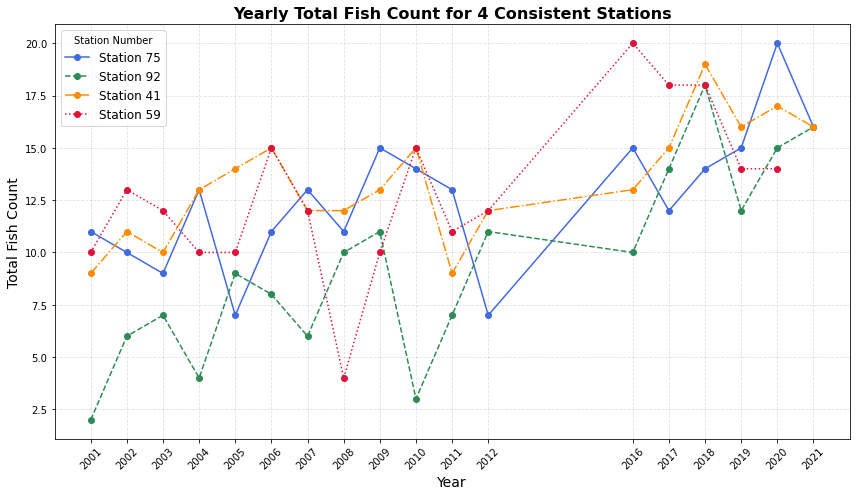

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)

# 排除数据稀少的年份
df = df[~df['Year'].isin([2013, 2014, 2015])]

# 你提供的 4 个 consistent station number
consistent_station_numbers = [75, 92, 41, 59]

# 筛选数据
df = df[df['Station Number'].isin(consistent_station_numbers)]

# 可选的颜色和线型风格
colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']
linestyles = ['-', '--', '-.', ':']

# 画图
plt.figure(figsize=(12, 7))

for i, station in enumerate(consistent_station_numbers):
    df_station = df[df['Station Number'] == station]
    yearly_species = df_station.groupby('Year')['Species Count'].sum()
    
    # 🔧 保证是1D numpy array
    x = yearly_species.index.to_numpy()
    y = yearly_species.to_numpy().flatten()

    plt.plot(
        x,
        y,
        marker='o',
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        label=f'Station {station}'
    )

# 图表样式美化
plt.title('Yearly Total Fish Count for 4 Consistent Stations', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Fish Count', fontsize=14)
plt.xticks(sorted(df['Year'].unique()), rotation=45)
plt.legend(title='Station Number', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


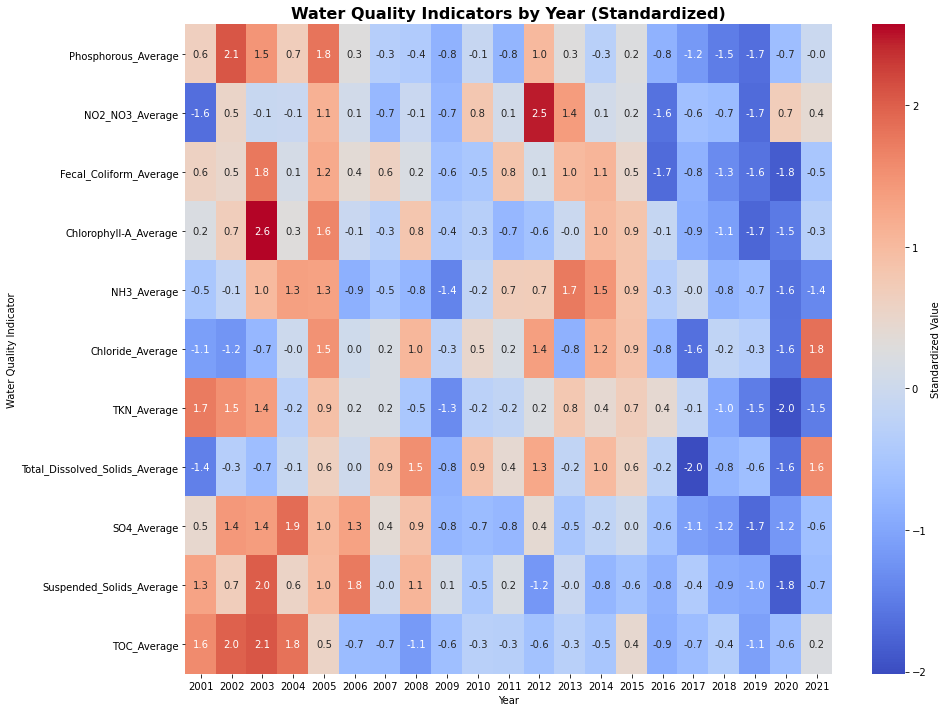

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 读取数据
df = pd.read_csv('chemical_water_quality_cleaned.csv')
df = df[~df['Year'].isin([2022,2023,2024,2025])]

df['Year'] = df['Year'].astype(int)

# 🔍 只保留水质指标：保留列名中含 "Average" 的列
wq_columns = [col for col in df.columns if 'Average' in col]

# 强制转换为数值，避免脏数据
df[wq_columns] = df[wq_columns].apply(pd.to_numeric, errors='coerce')

# 每年平均值
yearly_wq_avg = df.groupby('Year')[wq_columns].mean()

# 标准化 z-score
scaler = StandardScaler()
yearly_scaled = pd.DataFrame(
    scaler.fit_transform(yearly_wq_avg),
    index=yearly_wq_avg.index,
    columns=wq_columns
)

# 画热力图
plt.figure(figsize=(14, 10))
sns.heatmap(yearly_scaled.T, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Standardized Value'})
plt.title('Water Quality Indicators by Year (Standardized)', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Water Quality Indicator')
plt.tight_layout()
plt.show()


In [84]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.lines import Line2D

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')

# 非鱼类列
meta_and_chemical_cols = [
    'Fish Count', 'Species Count', 'Station Number', 'Station Name', 'Waterway', 'Year', 'x', 'y',
    'Phosphorous_Average', 'Phosphorous_Min', 'Phosphorous_Max',
    'NO2_NO3_Average', 'NO2_NO3_Min', 'NO2_NO3_Max',
    'Fecal_Coliform_Average', 'Fecal_Coliform_Min', 'Fecal_Coliform_Max',
    'Chlorophyll-A_Average', 'Chlorophyll-A_Min', 'Chlorophyll-A_Max',
    'NH3_Average', 'NH3_Min', 'NH3_Max',
    'Chloride_Average', 'Chloride_Min', 'Chloride_Max',
    'TKN_Average', 'TKN_Min', 'TKN_Max',
    'Total_Dissolved_Solids_Average', 'Total_Dissolved_Solids_Min', 'Total_Dissolved_Solids_Max',
    'SO4_Average', 'SO4_Min', 'SO4_Max',
    'Suspended_Solids_Average', 'Suspended_Solids_Min', 'Suspended_Solids_Max',
    'TOC_Average', 'TOC_Min', 'TOC_Max'
]
fish_columns = [col for col in df.columns if col not in meta_and_chemical_cols and not col.startswith('Unnamed')]

# 构建网络
G = nx.Graph()
co_occurrence = {}
fish_totals = {fish: 0 for fish in fish_columns}

for _, row in df.iterrows():
    present_fish = [fish for fish in fish_columns if row[fish] > 0]
    for fish1, fish2 in combinations(sorted(present_fish), 2):
        pair = tuple(sorted([fish1, fish2]))
        co_occurrence[pair] = co_occurrence.get(pair, 0) + 1
    for fish in present_fish:
        fish_totals[fish] += row[fish]

for fish, total_count in fish_totals.items():
    if total_count > 0:
        G.add_node(fish, size=total_count)

for (fish1, fish2), weight in co_occurrence.items():
    G.add_edge(fish1, fish2, weight=weight)

# 布局
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(G, k=9.2, iterations=100, seed=42)

# 获取 top 10 最粗边
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
top_edges = set((e[0], e[1]) for e in sorted_edges[:10])

# 节点大小
node_sizes = [G.nodes[n]['size'] * 0.4 for n in G.nodes]

# 分两批画边
regular_edges = [e for e in G.edges if tuple(sorted(e)) not in top_edges]
highlight_edges = [e for e in G.edges if tuple(sorted(e)) in top_edges]

# 边宽
edge_widths_regular = [G.edges[e]['weight'] * 0.1 for e in regular_edges]
edge_widths_top = [G.edges[e]['weight'] * 0.06 for e in highlight_edges]

# 画图
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=regular_edges, width=edge_widths_regular, edge_color='gray', alpha=0.4)
nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, width=edge_widths_top, edge_color='darkorange', alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=12)

# 图例
legend_elements = [
    Line2D([0], [0], color='darkorange', lw=5, label='Top 10 Co-occurrence'),
    Line2D([0], [0], color='gray', lw=5, label='Other Co-occurrence'),
    Line2D([0], [0], marker='o', color='w', label='Fish Species Node',
           markerfacecolor='skyblue', markersize=50)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True)

plt.title('Fish Co-occurrence Network\nOrange Edges = Top 10 Most Frequent Co-occurrences', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()


TypeError: '>' not supported between instances of 'str' and 'int'

之后要结合水质做共现网络，例如高污染下的网络，和低污染下的网络对比

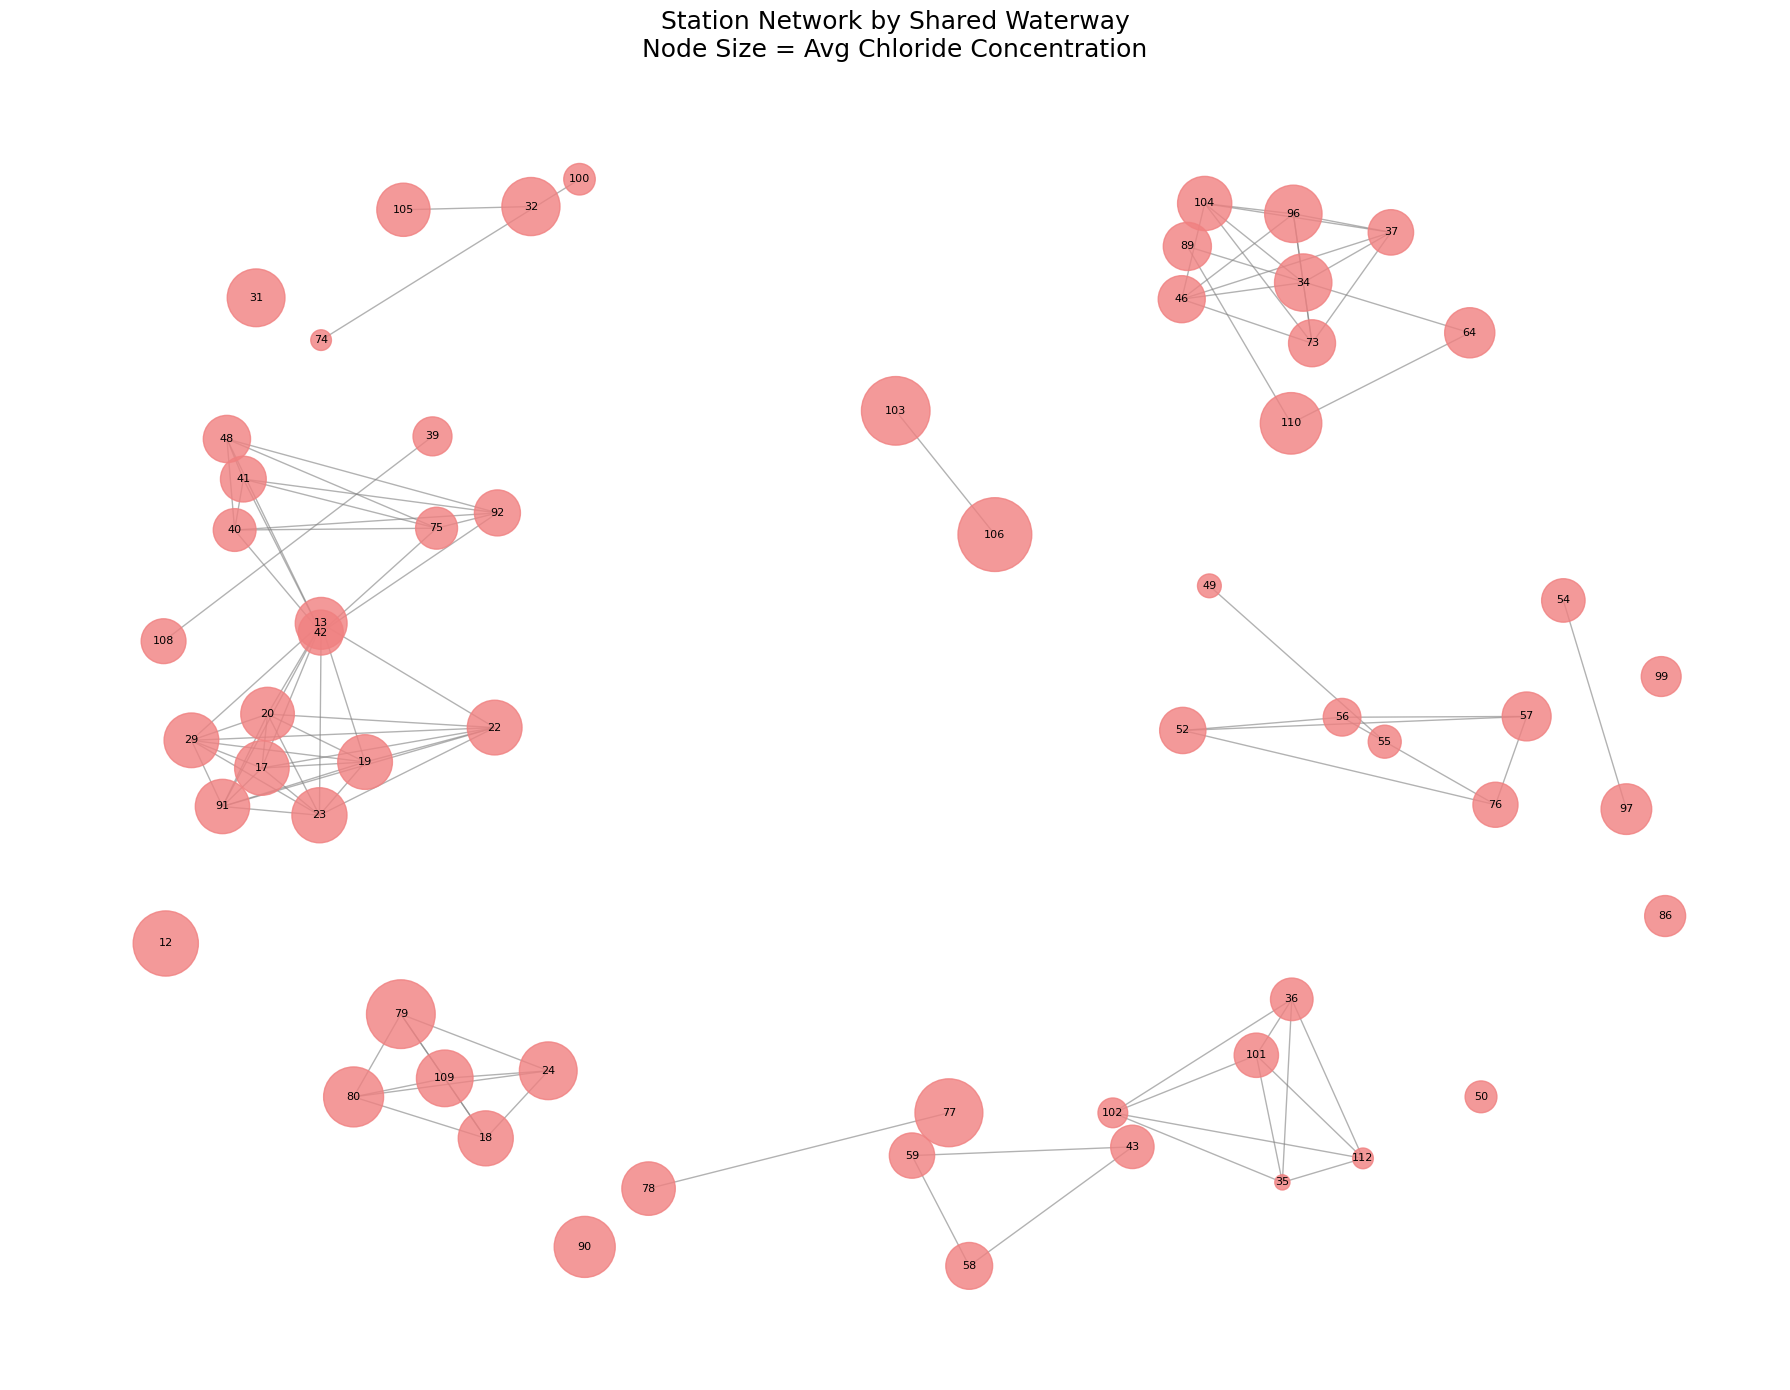

In [71]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')

# 保证字段格式一致
df['Station Number'] = df['Station Number'].astype(str)
df['Waterway'] = df['Waterway'].astype(str)

# Step 1: 计算每个站点的 Chloride_Average（取平均）
station_chloride = df.groupby('Station Number')['Chloride_Average'].mean().to_dict()

# Step 2: 构建 Waterway → Station 列表字典
waterway_station_map = df.groupby('Waterway')['Station Number'].unique().to_dict()

# Step 3: 构建图（连同一水道的所有站点）
G = nx.Graph()

# 添加节点
for station, chloride_value in station_chloride.items():
    if pd.notna(chloride_value):
        G.add_node(station, chloride=chloride_value)

# 添加边：同一河道中的任意两站点相连
for station_list in waterway_station_map.values():
    stations = list(set(station_list))  # 防重复
    for i in range(len(stations)):
        for j in range(i+1, len(stations)):
            if G.has_node(stations[i]) and G.has_node(stations[j]):
                G.add_edge(stations[i], stations[j])

# 可视化
plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=1, iterations=100, seed=42)

# 节点大小按 chloride 值缩放
node_sizes = [G.nodes[n]['chloride'] * 8 for n in G.nodes]

# 绘图
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Station Network by Shared Waterway\nNode Size = Avg Chloride Concentration', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from numpy.core import getlimits
np.MachAr = getlimits.MachAr
import pandas as pd


In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 1. Load data
df = pd.read_csv('combined_df_expanded_species.csv')

# 2. (Optional) drop sparse years
# df = df[~df['Year'].isin([2013, 2014, 2015])]

# 3. Drop missing Fish Count
df = df.dropna(subset=['Fish Count'])

# 4. Select predictors
predictors = [col for col in df.columns if col.endswith('_Average')]

# 5. Drop any rows missing predictors
df = df.dropna(subset=predictors)

# 6. Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df[predictors])
y = df['Fish Count'].values

# 7. Fit Linear Regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# 8. Output results
print(f"R²: {r2_score(y, y_pred):.3f}")
print(f"Intercept: {model.intercept_:.3f}\n")
print("Coefficients:")
for feat, coef in zip(predictors, model.coef_):
    print(f"  {feat:<25} {coef:>8.3f}")


R²: 0.211
Intercept: 182.062

Coefficients:
  Phosphorous_Average         36.573
  NO2_NO3_Average            -26.718
  Fecal_Coliform_Average      16.058
  Chlorophyll-A_Average       10.391
  NH3_Average                 34.816
  Chloride_Average           -14.406
  TKN_Average                -38.236
  Total_Dissolved_Solids_Average  -31.349
  SO4_Average                  8.071
  Suspended_Solids_Average   -56.997
  TOC_Average                -40.255


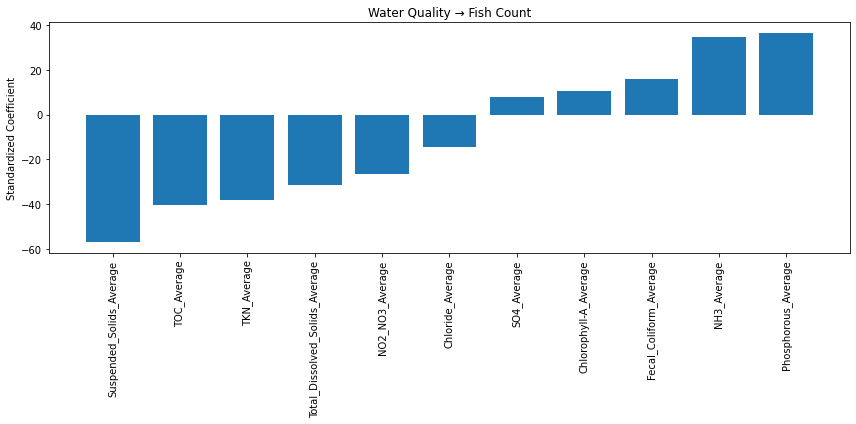

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === USER: set your local path to the merged dataset ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. Load data
df = pd.read_csv(DATA_PATH)

# 2. (Optional) drop sparse years
# df = df[~df['Year'].isin([2013, 2014, 2015])]

# 3. Clean: drop missing Fish Count or predictors
df = df.dropna(subset=['Fish Count'])
predictors = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=predictors)

# 4. Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df[predictors])
y = df['Fish Count'].values

# 5. Fit model
model = LinearRegression().fit(X, y)

# 6. Extract & sort coefficients
coef = pd.Series(model.coef_, index=predictors).sort_values()

# 7. Plot
plt.figure(figsize=(12,6))
plt.bar(coef.index, coef.values)
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.title('Water Quality → Fish Count')
plt.tight_layout()
plt.show()


Random Forest R²: 0.890
Random Forest RMSE: 78.625


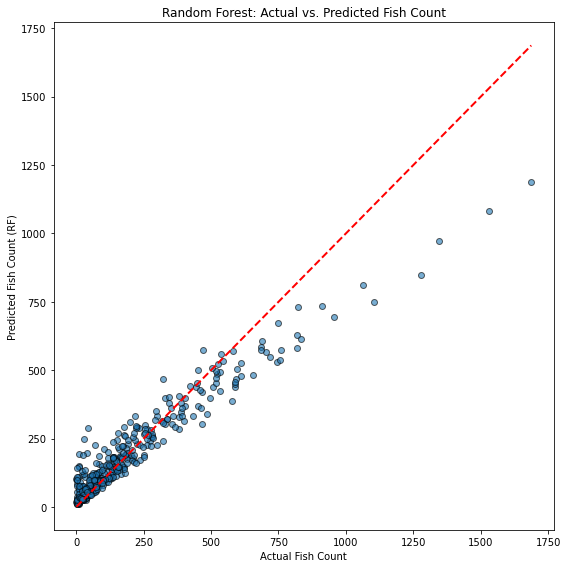

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# === USER: set your local path to the merged dataset ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. Load data
df = pd.read_csv(DATA_PATH)

# 2. Drop missing Fish Count or predictors
df = df.dropna(subset=['Fish Count'])
predictors = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=predictors)

# 3. Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df[predictors])
y = df['Fish Count'].values

# 4. Fit a Random Forest Regressor (non-linear model)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred = rf.predict(X)

# 5. Evaluate
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f"Random Forest R²: {r2:.3f}")
print(f"Random Forest RMSE: {rmse:.3f}")

# 6. Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Fish Count')
plt.ylabel('Predicted Fish Count (RF)')
plt.title('Random Forest: Actual vs. Predicted Fish Count')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.model_selection import train_test_split, cross_val_score

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)

# 2. Evaluate
from sklearn.metrics import r2_score, mean_squared_error
print("Test  R²:", r2_score(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

# Or use cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("5-fold CV R² mean:", cv_scores.mean())


Test  R²: 0.2750970357874689
Test RMSE: 226.7625959146534
5-fold CV R² mean: -0.4009941104249625


In [14]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
print(feat_imp)


Suspended_Solids_Average          0.186373
Chloride_Average                  0.144146
Fecal_Coliform_Average            0.137516
Total_Dissolved_Solids_Average    0.118628
NO2_NO3_Average                   0.086718
SO4_Average                       0.085425
Phosphorous_Average               0.069208
NH3_Average                       0.065648
Chlorophyll-A_Average             0.055777
TOC_Average                       0.040864
TKN_Average                       0.009696
dtype: float64


Suspended_Solids_Average          0.186373
Chloride_Average                  0.144146
Fecal_Coliform_Average            0.137516
Total_Dissolved_Solids_Average    0.118628
NO2_NO3_Average                   0.086718
SO4_Average                       0.085425
Phosphorous_Average               0.069208
NH3_Average                       0.065648
Chlorophyll-A_Average             0.055777
TOC_Average                       0.040864
dtype: float64


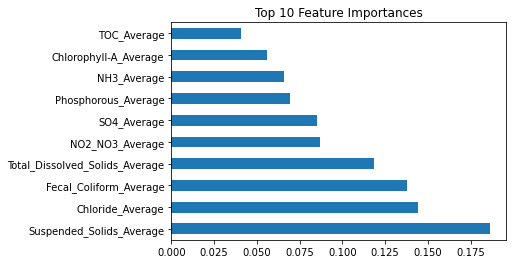

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
print(feat_imp.head(10))
feat_imp.head(10).plot.barh(title="Top 10 Feature Importances")
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# === 请将下面路径替换为你的本地文件路径 ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. 载入数据
df = pd.read_csv(DATA_PATH)

# 2. 清洗：去除 Fish Count 或关键预测变量缺失的行
df = df.dropna(subset=['Fish Count',
    'Suspended_Solids_Average', 'Chloride_Average', 'Fecal_Coliform_Average',
    'Total_Dissolved_Solids_Average', 'NO2_NO3_Average'
])

# 3. 划分训练/测试集
X = df[['Suspended_Solids_Average', 'Chloride_Average', 'Fecal_Coliform_Average',
        'Total_Dissolved_Solids_Average', 'NO2_NO3_Average']]
y = df['Fish Count']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Ridge 回归（内置 5 折 CV 选 α）
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5).fit(X_train_scaled, y_train)
ridge_r2 = r2_score(y_test, ridge.predict(X_test_scaled))

# 6. 随机森林（同样只用这五个变量）
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
rf_r2 = r2_score(y_test, rf.predict(X_test_scaled))

print(f"Ridge (top5) Test R²: {ridge_r2:.3f}")
print(f"RF (top5)    Test R²: {rf_r2:.3f}")


Ridge (top5) Test R²: 0.167
RF (top5)    Test R²: 0.198


In [27]:
import pandas as pd

# 1. Load the existing CSV
path = 'combined_df_expanded_species.csv'
df = pd.read_csv(path)

# 2. Rename columns: replace 'Chlorophyll-A' with 'Chlorophyll_A'
df.columns = [col.replace('Chlorophyll-A', 'Chlorophyll_A') for col in df.columns]

# 3. Save back to the same file
df.to_csv(path, index=False)

# 4. Report back
print("Columns successfully updated. Here are the new column names:")
print([col for col in df.columns if 'Chlorophyll_A' in col])


Columns successfully updated. Here are the new column names:
['Chlorophyll_A_Average', 'Chlorophyll_A_Min', 'Chlorophyll_A_Max']


In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

# === USER: update path to your local file ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. Load data
df = pd.read_csv(DATA_PATH)

# 2. Clean: drop rows missing Fish Count or any average chemical
df = df.dropna(subset=['Fish Count'])
chemical_avg = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=chemical_avg)

# 3. Rename columns to avoid formula parsing issues
df.columns = df.columns.str.replace('-', '_')

# 4. Reset index to ensure contiguous indexing
df = df.reset_index(drop=True)

# 5. Standardize chemical predictors
scaler = StandardScaler()
df[chemical_avg] = scaler.fit_transform(df[chemical_avg])

# 6. Prepare grouping variable
df['Station'] = df['Station Number'].astype('category')

# 7. Build formula
fixed_effects = ' + '.join(chemical_avg)
formula = f'Q("Fish Count") ~ {fixed_effects}'

# 8. Fit mixed effects model
md = smf.mixedlm(formula, df, groups=df['Station'])
mdf = md.fit(reml=False)

# 9. Print summary
print(mdf.summary())



                    Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Q("Fish Count")
No. Observations:       417          Method:                  ML             
No. Groups:             60           Scale:                   36389.4258     
Min. group size:        2            Log-Likelihood:          -2806.4942     
Max. group size:        19           Converged:               Yes            
Mean group size:        7.0                                                  
-----------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       159.554   16.638  9.590 0.000 126.943 192.165
Phosphorous_Average              34.568   20.248  1.707 0.088  -5.118  74.253
NO2_NO3_Average                 -24.785   21.293 -1.164 0.244 -66.518  16.949
Fecal_

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# === USER: set this to your local CSV path ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. load data
df = pd.read_csv(DATA_PATH)

# 2. filter out years 2013-2015 and drop missing
df = df[~df['Year'].isin([2013, 2014, 2015])]
df = df.dropna(subset=['Fish Count'])
chem_avgs = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=chem_avgs + ['Station Number'])

# 3. standardize predictors
scaler = StandardScaler()
df[chem_avgs] = scaler.fit_transform(df[chem_avgs])

# 4. prepare stations list
stations = [75, 92, 41, 59]

# 5. loop over stations
for st in stations:
    sub = df[df['Station Number'] == st]
    X = sub[chem_avgs].values
    y = sub['Fish Count'].values
    
    # fit sklearn linear model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # print results
    print(f"\nStation {st} (n={len(y)}):")
    print(f"  R² = {r2:.3f}")
    print(f"  Intercept = {model.intercept_:.3f}")
    print("  Coefficients:")
    for feat, coef in zip(chem_avgs, model.coef_):
        print(f"    {feat:<30} {coef:>8.3f}")



Station 75 (n=18):
  R² = 0.832
  Intercept = -1612.649
  Coefficients:
    Phosphorous_Average            -929.932
    NO2_NO3_Average                 408.054
    Fecal_Coliform_Average         -3506.876
    Chlorophyll_A_Average           -13.020
    NH3_Average                    -105.085
    Chloride_Average               -574.077
    TKN_Average                       0.055
    Total_Dissolved_Solids_Average  278.435
    SO4_Average                     790.175
    Suspended_Solids_Average        -30.406
    TOC_Average                     -83.010

Station 92 (n=18):
  R² = 0.837
  Intercept = -1138.085
  Coefficients:
    Phosphorous_Average            1519.842
    NO2_NO3_Average                -693.000
    Fecal_Coliform_Average         -1625.268
    Chlorophyll_A_Average          -595.546
    NH3_Average                    -217.894
    Chloride_Average               1165.494
    TKN_Average                    -161.819
    Total_Dissolved_Solids_Average -460.196
    SO4_Average 

/Users/sys/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sys/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sys/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/sys/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/U

Best Params: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Test R²: 0.358443324004613
Test RMSE: 213.32855738760915


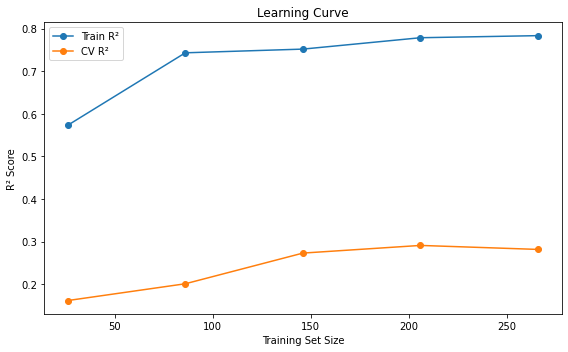

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# === USER: 修改为你本地的路径 ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. 载入并清洗
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=['Fish Count'])
predictors = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=predictors)

# 2. 划分训练/测试集
X = df[predictors].values
y = df['Fish Count'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. 随机搜索调参
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 0.5, 0.8]
}
rf = RandomForestRegressor(random_state=42)
rs = RandomizedSearchCV(
    rf, param_dist,
    n_iter=20, cv=5,
    scoring='r2', n_jobs=-1, random_state=42
)
rs.fit(X_train, y_train)
best = rs.best_estimator_

# 5. 测试集评估
y_pred = best.predict(X_test)
print("Best Params:", rs.best_params_)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 6. 学习曲线检查过拟合
train_sizes, train_scores, val_scores = learning_curve(
    best, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train R²')
plt.plot(train_sizes, val_mean, 'o-', label='CV R²')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}
rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist, n_iter=30, cv=5,
    scoring='r2', n_jobs=-1, random_state=42,
    error_score='raise'
)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='r2')

In [36]:
# 最优参数
print("Best params:", rs.best_params_)

# 最优的交叉验证得分（R²）
print("Best CV R²:", rs.best_score_)


Best params: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
Best CV R²: 0.2773564004591358


In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# === USER: set this to your local CSV path ===
DATA_PATH = 'combined_df_expanded_species.csv'

# 1. Load data
df = pd.read_csv(DATA_PATH)

# 2. Prepare target and predictors
df = df.dropna(subset=['Species Count'])
chem_avg = [c for c in df.columns if c.endswith('_Average')]
df = df.dropna(subset=chem_avg)

X = df[chem_avg].values
y = df['Species Count'].values

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# 6. Permutation Importance
perm_imp = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({
    'feature': chem_avg,
    'importance': perm_imp.importances_mean
}).sort_values('importance', ascending=False)

# 7. Partial Dependence to get direction (+/-)
directions = {}
for i, feature in enumerate(chem_avg):
    # compute PDP at 25th and 75th percentiles
    q_low, q_high = np.percentile(X_test_scaled[:, i], [25, 75])
    pdp_low = rf.predict(np.array(X_test_scaled.mean(axis=0)).reshape(1, -1) + 0*(X_test_scaled[0]))
    # Create samples where only this feature varies
    sample = X_test_scaled.mean(axis=0).reshape(1, -1)
    sample_low = sample.copy()
    sample_low[0, i] = q_low
    sample_high = sample.copy()
    sample_high[0, i] = q_high
    pred_low = rf.predict(sample_low)
    pred_high = rf.predict(sample_high)
    directions[feature] = 'positive' if pred_high > pred_low else 'negative'

# 8. Combine results
imp_df['direction'] = imp_df['feature'].map(directions)

# Display results
import pprint
print("Feature importance and direction:")
pprint.pprint(imp_df.reset_index(drop=True))


Feature importance and direction:
                           feature  importance direction
0   Total_Dissolved_Solids_Average    0.219989  negative
1           Fecal_Coliform_Average    0.100323  negative
2                      TOC_Average    0.070481  negative
3                      NH3_Average    0.061762  negative
4         Suspended_Solids_Average    0.037607  positive
5            Chlorophyll_A_Average    0.016958  positive
6                      TKN_Average    0.015697  negative
7                  NO2_NO3_Average    0.015694  positive
8                      SO4_Average    0.014241  positive
9                 Chloride_Average    0.009569  negative
10             Phosphorous_Average   -0.012592  positive


In [2]:
import pandas as pd

# Load the main dataset
df = pd.read_csv('combined_df_expanded_species.csv')

# Ensure numeric types for pollutants
pollutants = ['Suspended_Solids_Average', 'TOC_Average', 'Total_Dissolved_Solids_Average']
for p in pollutants:
    df[p] = pd.to_numeric(df[p], errors='coerce')

# 1. 查看基本统计量，判断结果范围是否合理
print(df[pollutants].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# 2. 以 Suspended Solids 四分位数分组
q1 = df['Suspended_Solids_Average'].quantile(0.25)
q3 = df['Suspended_Solids_Average'].quantile(0.75)
df['SS_group'] = pd.cut(
    df['Suspended_Solids_Average'],
    bins=[-float('inf'), q1, q3, float('inf')],
    labels=['Low SS', 'Mid SS', 'High SS']
)

# 3. 按年份和组别统计 station-year 数量，检查分布
distribution = df.groupby(['Year', 'SS_group']).size().unstack(fill_value=0)
print(distribution)


                                      mean         std    min    25%    50%  \
Suspended_Solids_Average         17.873206   11.040397    1.0   10.0   15.0   
TOC_Average                       5.794258    2.892273    1.0    4.0    5.0   
Total_Dissolved_Solids_Average  631.606715  167.055837  220.0  538.0  627.0   

                                  75%     max  
Suspended_Solids_Average         23.0    89.0  
TOC_Average                       7.0    43.0  
Total_Dissolved_Solids_Average  723.0  1409.0  
SS_group  Low SS  Mid SS  High SS
Year                             
2001           4      16        7
2002           3      15        4
2003           7       5       12
2004           4      13       11
2005           4      15        8
2006           4      13        6
2007           6      13        6
2008           5       9       15
2009           6      16        5
2010          11      12        1
2011           6      11        6
2012           8      15        4
2013           

In [21]:
import pandas as pd

df = pd.read_csv('combined_df_expanded_species.csv')
# 确保数值型
df['Suspended_Solids_Average'] = pd.to_numeric(df['Suspended_Solids_Average'], errors='coerce')
# 按四分位分组
q1 = df['Suspended_Solids_Average'].quantile(0.25)
q3 = df['Suspended_Solids_Average'].quantile(0.75)
df['SS_group'] = pd.cut(df['Suspended_Solids_Average'],
                        bins=[-float('inf'), q1, q3, float('inf')],
                        labels=['Low SS', 'Mid SS', 'High SS'])

# 查看各组 Fish Count 分布
groups = df.groupby('SS_group')['Fish Count']
print("Fish Count by SS Group:\n", groups.describe())

# 找出 Fish Count 接近 300 的记录
target = 100
tolerance = 10  # 可调整
matches = df[(df['Fish Count'].between(target-tolerance, target+tolerance))]
print(f"\nStation–year with Fish Count ≈ {target} (±{tolerance}):\n", 
      matches[['Year','Station Number','SS_group','Fish Count']])


Fish Count by SS Group:
           count        mean         std  min     25%    50%     75%     max
SS_group                                                                   
Low SS    110.0  330.272727  304.389023  1.0  102.25  234.0  493.75  1531.0
Mid SS    209.0  161.961722  215.829323  2.0   31.00   77.0  205.00  1687.0
High SS    99.0   67.191919   68.626864  1.0   20.00   46.0   95.00   452.0

Station–year with Fish Count ≈ 100 (±10):
      Year  Station Number SS_group  Fish Count
28   2002              18   Mid SS         104
68   2003              58  High SS          95
138  2006              39   Mid SS          99
169  2007              49   Low SS         102
194  2008              77  High SS         107
197  2008              64  High SS          90
198  2008              12  High SS          95
237  2010              92   Low SS         103
268  2011              58  High SS         101
271  2011              46   Mid SS          95
311  2013              96  High SS

In [27]:
import pandas as pd

# Load dataset
df = pd.read_csv('combined_df_expanded_species.csv')

# Compute Suspended Solids groups (Low, Mid, High) based on quartiles
df['Suspended_Solids_Average'] = pd.to_numeric(df['Suspended_Solids_Average'], errors='coerce')
q_low = df['Suspended_Solids_Average'].quantile(0.25)
q_high = df['Suspended_Solids_Average'].quantile(0.75)
df['SS_group'] = pd.cut(
    df['Suspended_Solids_Average'],
    bins=[-float('inf'), q_low, q_high, float('inf')],
    labels=['Low SS', 'Mid SS', 'High SS']
)

# Identify stations that appear in all three SS_group categories
station_group_counts = df.groupby('Station Number')['SS_group'].nunique()
stations_three = station_group_counts[station_group_counts == 3].index.tolist()

# Display the stations and their group memberships
print("Stations recorded in all three SS groups:")
for st in stations_three:
    groups = df[df['Station Number'] == st]['SS_group'].unique()
    print(f"Station {st}: {list(groups)}")


Stations recorded in all three SS groups:
Station 56: ['High SS', 'Mid SS', 'Low SS']


In [29]:
import pandas as pd

# 1. Load the dataset (adjust path as needed)
df = pd.read_csv('combined_df_expanded_species.csv')

# 2. Ensure Suspended Solids is numeric and compute SS_group by quartiles
df['Suspended_Solids_Average'] = pd.to_numeric(df['Suspended_Solids_Average'], errors='coerce')
q_low = df['Suspended_Solids_Average'].quantile(0.25)
q_high = df['Suspended_Solids_Average'].quantile(0.75)
df['SS_group'] = pd.cut(
    df['Suspended_Solids_Average'],
    bins=[-float('inf'), q_low, q_high, float('inf')],
    labels=['Low SS', 'Mid SS', 'High SS']
)

# 3. Filter for Station 56 and select Year, SS_group, and Fish Count
station_56 = (
    df[df['Station Number'] == 56]
    [['Year', 'SS_group', 'Fish Count']]
    .sort_values('Year')
)

# 4. Display the result
print("Station 56 — SS Group and Fish Count by Year:")
print(station_56.to_string(index=False))


Station 56 — SS Group and Fish Count by Year:
 Year SS_group  Fish Count
 2003  High SS         452
 2007   Mid SS         322
 2011   Mid SS         507
 2014   Mid SS        1344
 2016   Mid SS         517
 2017   Mid SS         443
 2018   Mid SS         447
 2019   Low SS         331
 2020   Low SS         685


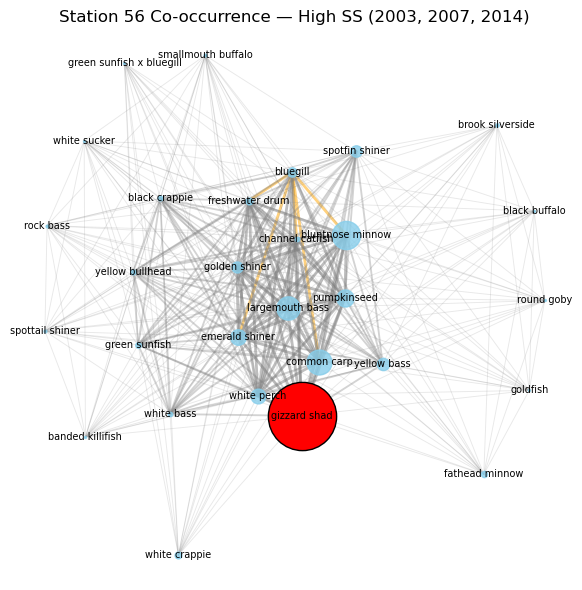

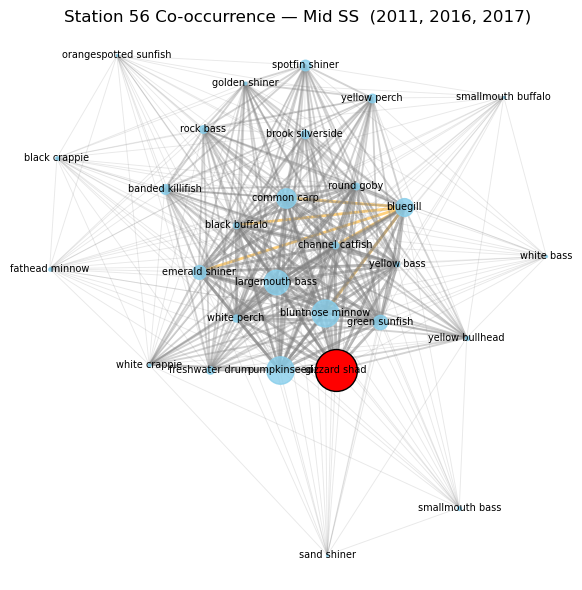

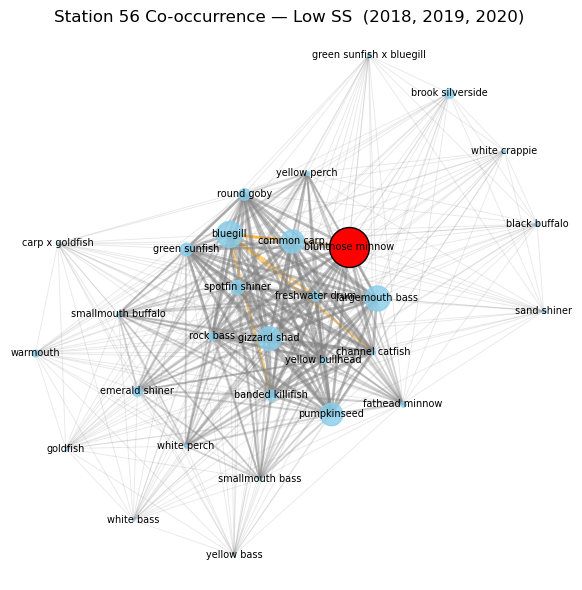

In [60]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. 读取数据
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)
df['Station Number'] = df['Station Number'].astype(int)

# 2. 自动识别鱼种列：TOC_Max 后面的所有列
cols = df.columns.tolist()
toc_max_idx = cols.index('TOC_Max')
fish_cols = cols[toc_max_idx+1:]

# 3. 构建共现网络函数
def build_cooccurrence_network(subdf, fish_columns):
    G = nx.Graph()
    co, totals = {}, {fish:0 for fish in fish_columns}
    for _, row in subdf.iterrows():
        present = [f for f in fish_columns if row[f] > 0]
        for f1, f2 in combinations(sorted(present), 2):
            co[(f1, f2)] = co.get((f1, f2), 0) + 1
        for f in present:
            totals[f] += row[f]
    for fish, cnt in totals.items():
        if cnt > 0:
            G.add_node(fish, abundance=cnt)
    for (f1, f2), w in co.items():
        G.add_edge(f1, f2, weight=w)
    return G

# 4. 绘图函数：白底、加权突出、前5边橙色高亮、最大节点红色
plt.style.use('default')
def plot_cooccurrence_network(G, title, k=0.8):
    # 布局
    pos = nx.spring_layout(G, k=k, iterations=100, seed=42)
    # 边权重列表
    edges_data = list(G.edges(data=True))
    weights = [d['weight'] for _,_,d in edges_data]
    max_w = max(weights) if weights else 1

    # 前 5 条最重的边 (只保留 (u,v))
    sorted_edges = sorted(edges_data, key=lambda x: x[2]['weight'], reverse=True)
    top5 = set((u, v) for u, v, _ in sorted_edges[:5])

    # 节点属性
    abundances = nx.get_node_attributes(G, 'abundance')
    max_node = max(abundances, key=abundances.get)

    # 绘图
    fig, ax = plt.subplots(figsize=(6,6), facecolor='white')
    ax.set_axis_off()
    ax.set_facecolor('white')

    # 画边
    for u, v, d in edges_data:
        w = d['weight']
        lw = (w / max_w) * 2 + 0
        alpha = (w / max_w) * 0.5 + 0.01
        color = 'orange' if (u, v) in top5 or (v, u) in top5 else 'gray'
        ax.plot(
            [pos[u][0], pos[v][0]],
            [pos[u][1], pos[v][1]],
            linewidth=lw,
            color=color,
            alpha=alpha,
            zorder=1
        )

    # 画节点
    for n, cnt in abundances.items():
        size = cnt * 2
        if n == max_node:
            ax.scatter(
                pos[n][0], pos[n][1],
                s=size,
                c='red',
                edgecolors='black',
                linewidths=1.0,
                zorder=2
            )
        else:
            ax.scatter(
                pos[n][0], pos[n][1],
                s=size,
                c='skyblue',
                alpha=0.8,
                zorder=2
            )

    # 添加标签
    for n in G.nodes():
        ax.text(
            pos[n][0], pos[n][1],
            n,
            fontsize=7,
            ha='center', va='center',
            zorder=3
        )

    # 标题
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    fig.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 5. 定义三个年份组，对应三种水质
year_groups = {
    'High SS (2003, 2007, 2014)': [2003, 2007, 2014],
    'Mid SS  (2011, 2016, 2017)': [2011, 2016, 2017],
    'Low SS  (2018, 2019, 2020)': [2018, 2019, 2020],
}

# 6. 在 Station 56 上绘制三张网络图
for label, years in year_groups.items():
    subdf = df[
        (df['Station Number'] == 56) &
        (df['Year'].isin(years))
    ]
    G = build_cooccurrence_network(subdf, fish_cols)
    plot_cooccurrence_network(
        G,
        title=f"Station 56 Co-occurrence — {label}",
        k=0.9
    )


In [55]:
import pandas as pd

# 读取数据（请根据实际路径修改）
df = pd.read_csv('combined_df_expanded_species.csv')

# 筛选 Station 56，并按年份显示 Suspended Solids 平均值
station_56_ss = (
    df[df['Station Number'] == 56]
    [['Year', 'Suspended_Solids_Average']]
    .sort_values('Year')
)

print("Station 56 Suspended Solids (Average) by Year:")
print(station_56_ss.to_string(index=False))


Station 56 Suspended Solids (Average) by Year:
 Year  Suspended_Solids_Average
 2003                      30.0
 2007                      22.0
 2011                      12.0
 2014                      17.0
 2016                      14.0
 2017                      12.0
 2018                      11.0
 2019                       9.0
 2020                       7.0


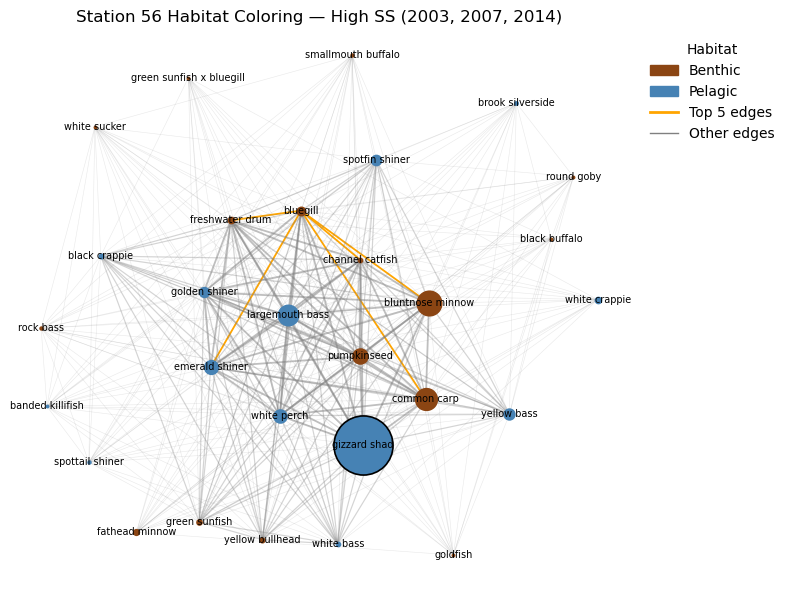

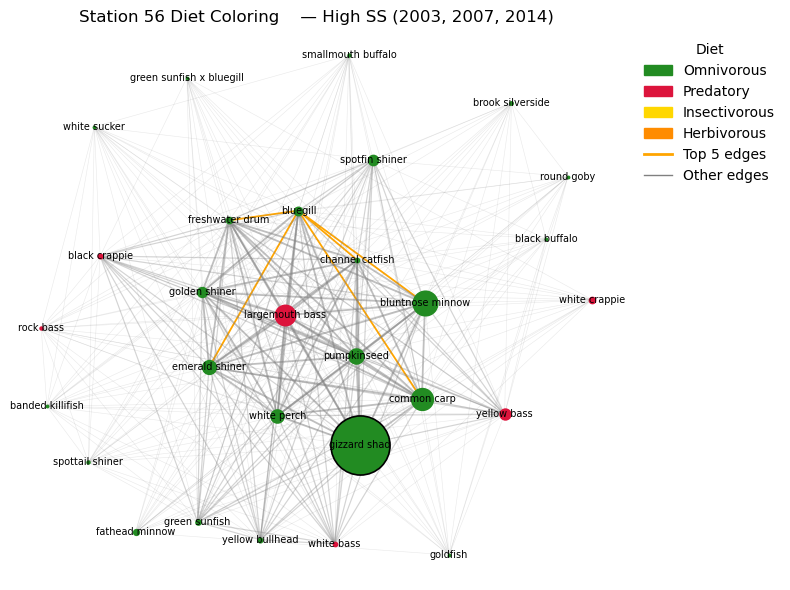

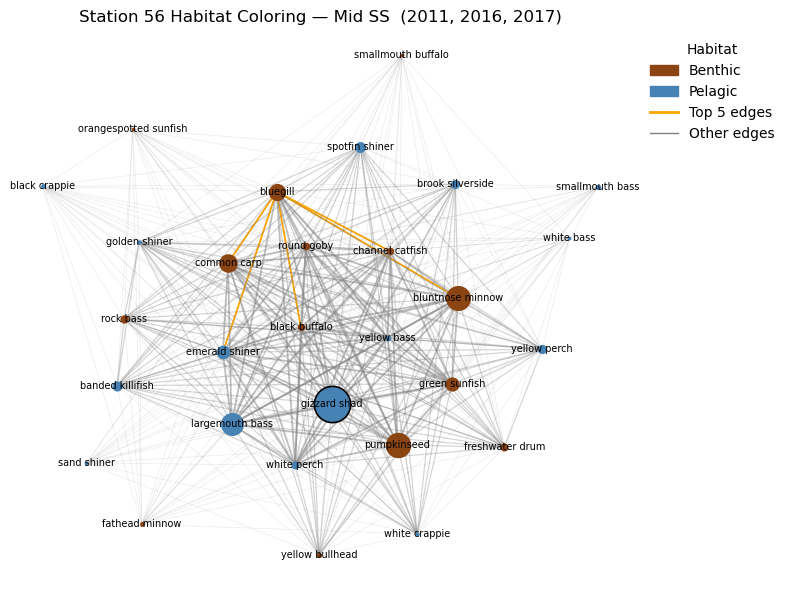

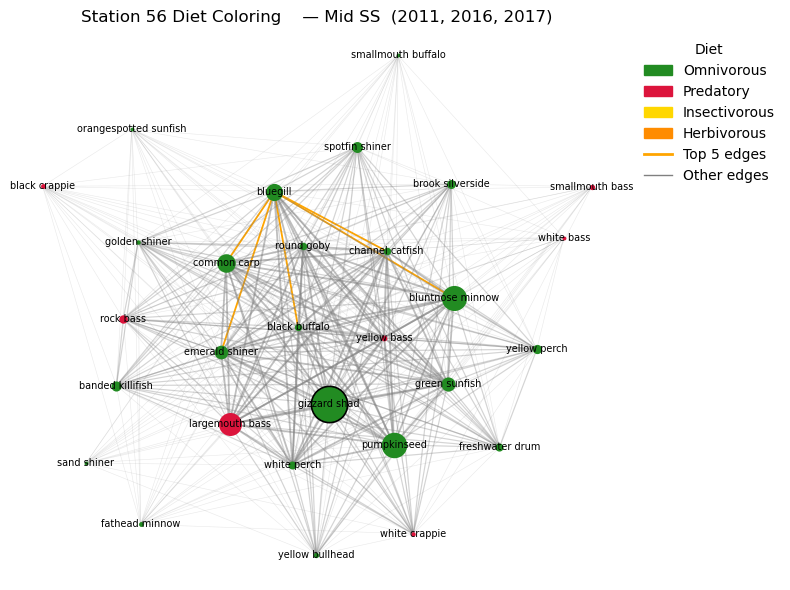

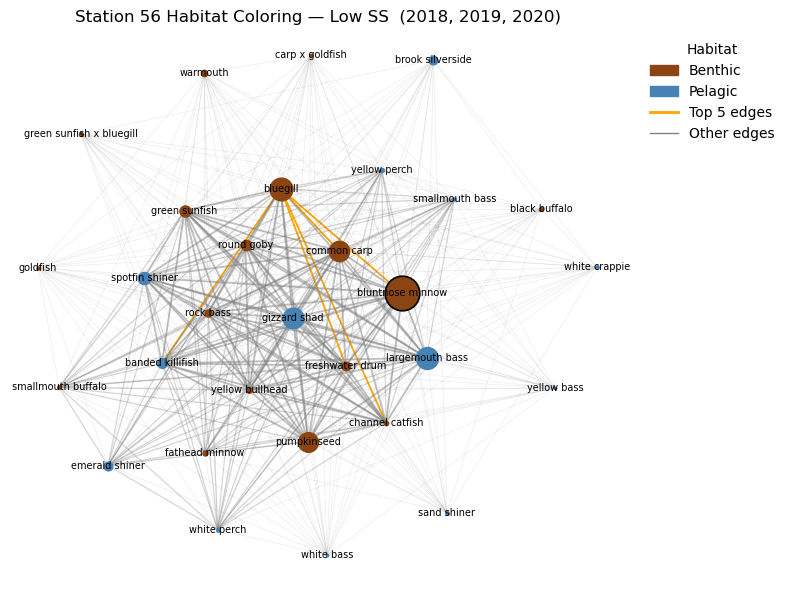

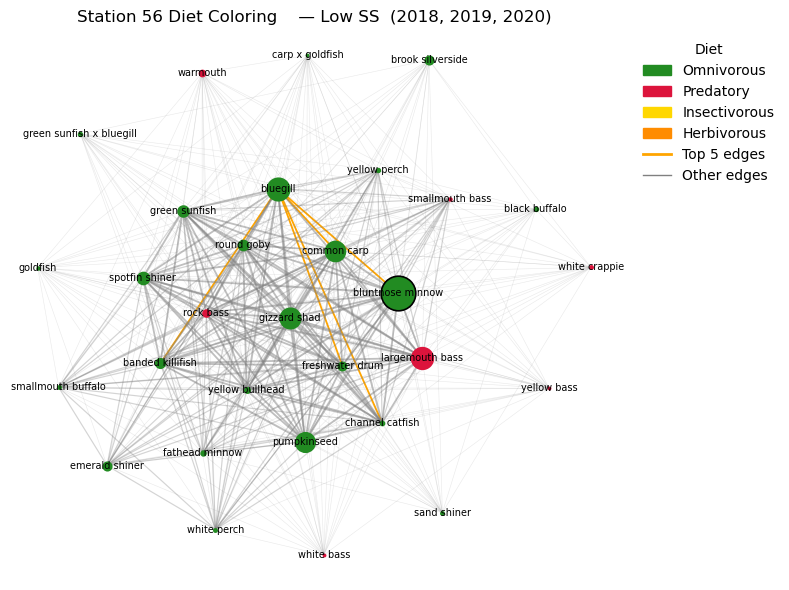

In [85]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1. Load data
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)
df['Station Number'] = df['Station Number'].astype(int)

# 2. Identify fish columns (everything after TOC_Max)
cols = df.columns.tolist()
toc_max_idx = cols.index('TOC_Max')
fish_cols = cols[toc_max_idx+1:]

# 3. Full classification mapping (all 77 species)
raw_class = {
    "Bigmouth Shiner": ("Pelagic", "Omnivorous"),
    "Bluegill": ("Benthic", "Omnivorous"),
    "Bluntnose Minnow": ("Benthic", "Omnivorous"),
    "Fathead Minnow": ("Benthic", "Omnivorous"),
    "Golden Shiner": ("Pelagic", "Omnivorous"),
    "Spotfin Shiner": ("Pelagic", "Omnivorous"),
    "White Sucker": ("Benthic", "Omnivorous"),
    "Common Carp": ("Benthic", "Omnivorous"),
    "Green Sunfish": ("Benthic", "Omnivorous"),
    "Largemouth Bass": ("Pelagic", "Predatory"),
    "Orangespotted Sunfish": ("Benthic", "Omnivorous"),
    "Yellow Bullhead": ("Benthic", "Omnivorous"),
    "Blackstripe Topminnow": ("Pelagic", "Omnivorous"),
    "Gizzard Shad": ("Pelagic", "Omnivorous"),
    "Johnny Darter": ("Benthic", "Insectivorous"),
    "Sand Shiner": ("Pelagic", "Omnivorous"),
    "Spottail Shiner": ("Pelagic", "Omnivorous"),
    "Channel Catfish": ("Benthic", "Omnivorous"),
    "Emerald Shiner": ("Pelagic", "Omnivorous"),
    "Grass Pickerel": ("Benthic", "Predatory"),
    "Mosquitofish": ("Pelagic", "Insectivorous"),
    "Black Bullhead": ("Benthic", "Omnivorous"),
    "Green Sunfish x Pumpkinseed": ("Benthic", "Omnivorous"),
    "Brook Stickleback": ("Benthic", "Insectivorous"),
    "Carp x Goldfish": ("Benthic", "Omnivorous"),
    "Goldfish": ("Benthic", "Omnivorous"),
    "Pumpkinseed": ("Benthic", "Omnivorous"),
    "Freshwater Drum": ("Benthic", "Omnivorous"),
    "Round Goby": ("Benthic", "Omnivorous"),
    "Smallmouth Bass": ("Pelagic", "Predatory"),
    "White Perch": ("Pelagic", "Omnivorous"),
    "Yellow Bass": ("Pelagic", "Predatory"),
    "Chinook Salmon": ("Pelagic", "Predatory"),
    "Grass Carp": ("Benthic", "Herbivorous"),
    "Quillback": ("Benthic", "Omnivorous"),
    "Rock Bass": ("Benthic", "Predatory"),
    "Creek Chub": ("Benthic", "Omnivorous"),
    "Black Crappie": ("Pelagic", "Predatory"),
    "Green Sunfish x Bluegill": ("Benthic", "Omnivorous"),
    "Walleye": ("Pelagic", "Predatory"),
    "Blackside Darter": ("Benthic", "Insectivorous"),
    "Pumpkinseed x Bluegill": ("Benthic", "Omnivorous"),
    "Warmouth": ("Benthic", "Predatory"),
    "Alewife": ("Pelagic", "Omnivorous"),
    "Skipjack Herring": ("Pelagic", "Omnivorous"),
    "Pirate Perch": ("Benthic", "Predatory"),
    "Longear Sunfish": ("Benthic", "Omnivorous"),
    "Black Buffalo": ("Benthic", "Omnivorous"),
    "White Bass": ("Pelagic", "Predatory"),
    "White Crappie": ("Pelagic", "Predatory"),
    "Northern Pike": ("Benthic", "Predatory"),
    "Spotted Sucker": ("Benthic", "Omnivorous"),
    "Tadpole Madtom": ("Benthic", "Omnivorous"),
    "Golden Redhorse": ("Benthic", "Omnivorous"),
    "Hornyhead Chub": ("Benthic", "Omnivorous"),
    "Bowfin": ("Benthic", "Predatory"),
    "Sauger": ("Pelagic", "Predatory"),
    "Yellow Perch": ("Pelagic", "Omnivorous"),
    "Central Mudminnow": ("Benthic", "Omnivorous"),
    "Brown Bullhead": ("Benthic", "Omnivorous"),
    "Green Sunfish x Longear": ("Benthic", "Omnivorous"),
    "Green Sunfish x Orangespot": ("Benthic", "Omnivorous"),
    "Brook Silverside": ("Pelagic", "Omnivorous"),
    "Smallmouth Buffalo": ("Benthic", "Omnivorous"),
    "Common Shiner": ("Pelagic", "Omnivorous"),
    "Fantail Darter": ("Benthic", "Insectivorous"),
    "Oriental Weatherfish": ("Benthic", "Omnivorous"),
    "Iowa Darter": ("Benthic", "Insectivorous"),
    "Banded Killifish": ("Pelagic", "Omnivorous"),
    "Flathead Catfish": ("Benthic", "Predatory"),
    "Central Stoneroller": ("Benthic", "Omnivorous"),
    "Mimic Shiner": ("Pelagic", "Omnivorous"),
    "Logperch": ("Benthic", "Insectivorous"),
    "Threadfin Shad": ("Pelagic", "Omnivorous"),
    "Longnose Gar": ("Benthic", "Predatory"),
    "Rosyface Shiner": ("Pelagic", "Omnivorous"),
    "Stonecat": ("Benthic", "Omnivorous"),
}
classification = {k.lower(): v for k, v in raw_class.items()}

# 4. Build co-occurrence network
def build_cooccurrence_network(subdf, fish_columns):
    G = nx.Graph()
    co, totals = {}, {fish:0 for fish in fish_columns}
    for _, row in subdf.iterrows():
        present = [f for f in fish_columns if row[f] > 0]
        for f1, f2 in combinations(sorted(present), 2):
            co[(f1, f2)] = co.get((f1, f2), 0) + 1
        for f in present:
            totals[f] += row[f]
    for fish, cnt in totals.items():
        if cnt > 0:
            G.add_node(fish, abundance=cnt)
    for (f1, f2), w in co.items():
        G.add_edge(f1, f2, weight=w)
    return G

# 5. Plot helper with legend
plt.style.use('default')
def plot_colored_network(G, title, color_by=0, k=6):
    pos = nx.spring_layout(G, k=k, iterations=100, seed=42)
    abundances = nx.get_node_attributes(G, 'abundance')
    max_node = max(abundances, key=abundances.get)
    edges_data = list(G.edges(data=True))
    weights = [d['weight'] for _,_,d in edges_data] or [1]
    max_w = max(weights)
    sorted_edges = sorted(edges_data, key=lambda x: x[2]['weight'], reverse=True)
    top5 = set((u, v) for u, v, _ in sorted_edges[:5])

    # Choose palette and map node colors case-insensitive
    if color_by == 0:
        palette = {"benthic":"saddlebrown", "pelagic":"steelblue"}
        cats = {n: classification.get(n.lower(),("",""))[0].lower() for n in G.nodes()}
        legend_nodes = [Patch(color=col, label=lab.capitalize()) for lab,col in palette.items()]
        legend_edges = [Line2D([0],[0], color='orange', lw=2, label='Top 5 edges'),
                        Line2D([0],[0], color='gray', lw=1, label='Other edges')]
    else:
        palette = {"omnivorous":"forestgreen", "predatory":"crimson",
                   "insectivorous":"gold", "herbivorous":"darkorange"}
        cats = {n: classification.get(n.lower(),("",""))[1].lower() for n in G.nodes()}
        legend_nodes = [Patch(color=col, label=lab.capitalize()) for lab,col in palette.items()]
        legend_edges = [Line2D([0],[0], color='orange', lw=2, label='Top 5 edges'),
                        Line2D([0],[0], color='gray', lw=1, label='Other edges')]

    node_colors = [palette.get(cats[n], "lightgray") for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(8,6), facecolor='white')
    ax.set_facecolor('white'); ax.set_axis_off()

    # Draw edges
        # Draw edges
    for u, v, d in edges_data:
        w = d['weight']
        lw = (w / max_w) * 1.3 + 0
        # fully opaque for top5, otherwise scaled
        if (u, v) in top5 or (v, u) in top5:
            color = 'orange'
            alpha_edge = 1.0
        else:
            color = 'gray'
            alpha_edge = (w / max_w) * 0.5 + 0
        ax.plot([pos[u][0], pos[v][0]],
                [pos[u][1], pos[v][1]],
                linewidth=lw,
                color=color,
                alpha=alpha_edge,
                zorder=1)


    # Draw nodes
    for n in G.nodes():
        size=abundances[n]*1.5+1; ec='black' if n==max_node else None
        ax.scatter(pos[n][0],pos[n][1], s=size,
                   c=node_colors[list(G.nodes()).index(n)],
                   edgecolors=ec, linewidths=1.2, zorder=2)

    # Add labels
    for n in G.nodes():
        ax.text(pos[n][0],pos[n][1], n, fontsize=7,
                ha='center', va='center', zorder=3)

    # Add legends
    # position node legend top-left, edge legend below
    ax.legend(handles=legend_nodes + legend_edges,
              loc='upper left', bbox_to_anchor=(1.02, 1),
              title=("Habitat" if color_by==0 else "Diet"),
              frameon=False)

    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    fig.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 6. Year groups and plotting six graphs
year_groups = {
    'High SS (2003, 2007, 2014)': [2003, 2007, 2014],
    'Mid SS  (2011, 2016, 2017)': [2011, 2016, 2017],
    'Low SS  (2018, 2019, 2020)': [2018, 2019, 2020],
}

station = 56
for label, years in year_groups.items():
    sub = df[(df['Station Number']==station) & (df['Year'].isin(years))]
    G = build_cooccurrence_network(sub, fish_cols)
    plot_colored_network(G, f"Station 56 Habitat Coloring — {label}", color_by=0)
    plot_colored_network(G, f"Station 56 Diet Coloring    — {label}", color_by=1)


In [81]:
import pandas as pd
import networkx as nx
from itertools import combinations

# 1. Load data
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)
df['Station Number'] = df['Station Number'].astype(int)

# 2. Identify fish species columns (everything after 'TOC_Max')
cols = df.columns.tolist()
toc_max_idx = cols.index('TOC_Max')
fish_cols = cols[toc_max_idx+1:]

# 3. Function to build co‐occurrence network over a set of years
def build_cooccurrence_network(subdf):
    G = nx.Graph()
    co = {}
    totals = {fish: 0 for fish in fish_cols}
    for _, row in subdf.iterrows():
        present = [f for f in fish_cols if row[f] > 0]
        for f1, f2 in combinations(sorted(present), 2):
            co[(f1, f2)] = co.get((f1, f2), 0) + 1
        for f in present:
            totals[f] += row[f]
    for fish, cnt in totals.items():
        if cnt > 0:
            G.add_node(fish, abundance=cnt)
    for (f1, f2), w in co.items():
        G.add_edge(f1, f2, weight=w)
    return G

# 4. Define year groups
year_groups = {
    'High SS (2003, 2007, 2014)': [2003, 2007, 2014],
    'Mid SS  (2011, 2016, 2017)': [2011, 2016, 2017],
    'Low SS  (2018, 2019, 2020)': [2018, 2019, 2020],
}

# 5. Compute network metrics for Station 56 in each group
metrics = []
station = 56
for label, years in year_groups.items():
    sub = df[(df['Station Number'] == station) & (df['Year'].isin(years))]
    G = build_cooccurrence_network(sub)
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G) if n_nodes > 0 else 0
    n_components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len) if n_components > 0 else set()
    size_lcc = len(largest_cc)
    avg_degree = sum(dict(G.degree()).values()) / n_nodes if n_nodes > 0 else 0
    metrics.append({
        'Group': label,
        'Nodes': n_nodes,
        'Edges': n_edges,
        'Density': round(density, 4),
        'Avg Clustering': round(avg_clustering, 4),
        'Components': n_components,
        'Largest CC Size': size_lcc,
        'Avg Degree': round(avg_degree, 2)
    })

# 6. Display results
df_metrics = pd.DataFrame(metrics)
print(df_metrics.to_string(index=False))


                     Group  Nodes  Edges  Density  Avg Clustering  Components  Largest CC Size  Avg Degree
High SS (2003, 2007, 2014)     29    337   0.8300          0.9136           1               29       23.24
Mid SS  (2011, 2016, 2017)     29    371   0.9138          0.9435           1               29       25.59
Low SS  (2018, 2019, 2020)     30    390   0.8966          0.9409           1               30       26.00


In [82]:
import pandas as pd
import networkx as nx
from itertools import combinations

# 1. Load data
df = pd.read_csv('combined_df_expanded_species.csv')
df['Year'] = df['Year'].astype(int)
df['Station Number'] = df['Station Number'].astype(int)

# 2. Identify fish columns
cols = df.columns.tolist()
toc_max_idx = cols.index('TOC_Max')
fish_cols = cols[toc_max_idx+1:]

# 3. Build co‐occurrence network
def build_cooccurrence_network(subdf):
    G = nx.Graph()
    co = {}
    totals = {fish: 0 for fish in fish_cols}
    for _, row in subdf.iterrows():
        present = [f for f in fish_cols if row[f] > 0]
        for f1, f2 in combinations(sorted(present), 2):
            co[(f1, f2)] = co.get((f1, f2), 0) + 1
        for f in present:
            totals[f] += row[f]
    for fish, cnt in totals.items():
        if cnt > 0:
            G.add_node(fish, abundance=cnt)
    for (f1, f2), w in co.items():
        G.add_edge(f1, f2, weight=w)
    return G

# 4. Define year groups
year_groups = {
    'High SS (2003, 2007, 2014)': [2003, 2007, 2014],
    'Mid SS  (2011, 2016, 2017)': [2011, 2016, 2017],
    'Low SS  (2018, 2019, 2020)': [2018, 2019, 2020],
}

station = 56

# 5. Compute and print additional network metrics
for label, years in year_groups.items():
    sub = df[(df['Station Number'] == station) & (df['Year'].isin(years))]
    G = build_cooccurrence_network(sub)

    print(f"\n=== {label} ===")
    # Basic structural metrics
    print("Nodes:", G.number_of_nodes())
    print("Edges:", G.number_of_edges())
    print("Density:", round(nx.density(G), 4))
    print("Average clustering (unweighted):", round(nx.average_clustering(G), 4))
    print("Transitivity (global clustering):", round(nx.transitivity(G), 4))
    print("Connected components:", nx.number_connected_components(G))
    if nx.is_connected(G):
        print("Diameter:", nx.diameter(G))
        print("Average shortest path length:", round(nx.average_shortest_path_length(G), 4))
    else:
        print("Diameter: N/A (disconnected)")
        # can compute for largest component
        cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(cc)
        print("Avg path length (largest CC):", round(nx.average_shortest_path_length(H), 4))

    # Centrality measures
    deg_cent = nx.degree_centrality(G)
    bet_cent = nx.betweenness_centrality(G, weight=None)
    clo_cent = nx.closeness_centrality(G)
    eig_cent = nx.eigenvector_centrality(G, max_iter=1000)

    def top_n(metric_dict, n=5):
        return sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:n]

    print("Top 5 by degree centrality:", top_n(deg_cent))
    print("Top 5 by betweenness centrality:", top_n(bet_cent))
    print("Top 5 by closeness centrality:", top_n(clo_cent))
    print("Top 5 by eigenvector centrality:", top_n(eig_cent))



=== High SS (2003, 2007, 2014) ===
Nodes: 29
Edges: 337
Density: 0.83
Average clustering (unweighted): 0.9136
Transitivity (global clustering): 0.8838
Connected components: 1
Diameter: 2
Average shortest path length: 1.17
Top 5 by degree centrality: [('bluegill', 1.0), ('bluntnose minnow', 1.0), ('golden shiner', 1.0), ('common carp', 1.0), ('largemouth bass', 1.0)]
Top 5 by betweenness centrality: [('bluegill', 0.014031647364980696), ('bluntnose minnow', 0.014031647364980696), ('golden shiner', 0.014031647364980696), ('common carp', 0.014031647364980696), ('largemouth bass', 0.014031647364980696)]
Top 5 by closeness centrality: [('bluegill', 1.0), ('bluntnose minnow', 1.0), ('golden shiner', 1.0), ('common carp', 1.0), ('largemouth bass', 1.0)]
Top 5 by eigenvector centrality: [('bluegill', 0.21281605154211905), ('bluntnose minnow', 0.21281605154211905), ('golden shiner', 0.21281605154211905), ('common carp', 0.21281605154211905), ('largemouth bass', 0.21281605154211905)]

=== Mid SS